In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import csv
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
%matplotlib inline
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import cv2


In [4]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = 'e3c11603b207c8253d21825eae59c7bc'
os.environ["KAGGLE_USERNAME"] = 'gauravmanish834'

!kaggle datasets download -d jessicali9530/lfw-dataset


!unzip "lfw-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Si

In [5]:
def compute_hog(img):
  #resizing image
  resized_img = resize(img, (128*4, 64*4))
  #creating hog features
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)
  return fd


In [6]:
lfw_folder = '/content/lfw-deepfunneled/lfw-deepfunneled'
X, y = [],[]
for folder_name in os.listdir(lfw_folder):
    folder_path = os.path.join(lfw_folder, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        if num_images > 70:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = imread(image_path)
                hog_feature = compute_hog(image)
                # lbp_feature = calcLBP(image)
                # cnn_feature = extract_features(image_path, resnet).numpy()
                # hog_feature = hog_feature.reshape(-1)
                # lbp_feature = lbp_feature.reshape(-1)
                hog_feature = hog_feature.flatten()
                # combined_feature = np.concatenate((cnn_feature))

                X.append(hog_feature)
                y.append(folder_name)

In [7]:
X=np.array(X)
y=np.array(y)

In [8]:
y.shape

(1288,)

In [9]:
X

array([[3.60124561e-01, 0.00000000e+00, 1.48578647e-01, ...,
        3.18683235e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.86910163e-02, 0.00000000e+00, 0.00000000e+00, ...,
        6.18571458e-02, 1.14144418e-01, 2.73267149e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [10]:
X.shape

(1288, 70308)

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

# Fit the LDA model to the data
lda.fit(X, y)

LinearDiscriminantAnalysis()

In [12]:
print(lda.coef_.shape)

(7, 70308)


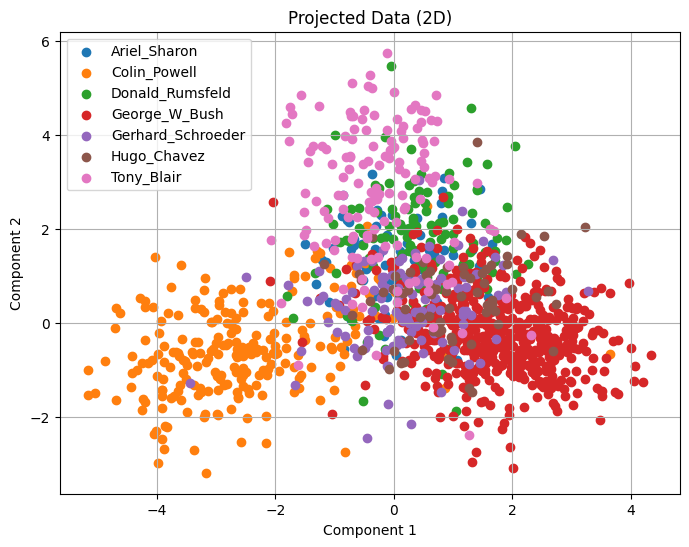

In [13]:
# Get the sorted eigenvalues and eigenvectors
eigenvalues = lda.explained_variance_ratio_
eigenvectors = lda.scalings_

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]  # Sort in descending order
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Select the top 7 components
top_components = sorted_eigenvectors

# Project the data onto the top 7 components
X_projected = np.dot(X, top_components)

# Plot the projected data
plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(X_projected[y == label, 0], X_projected[y == label, 1], label=label)
plt.title('Projected Data (2D)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
X_projected.shape  #so here the dimensionality reduced to 6 (n_classes-1, and in our data the number of classes are 7)

(1288, 6)